In [1]:
import numpy as np
import scipy.integrate as nint
from matplotlib import pyplot as plt
from plot_styler import style_plots
style_plots()

# circle

In [73]:
def circle_constraint(x):
    return 0.5 * (np.dot(x, x) - 1)


def circle_constraint_dt(x, xdot):
    return np.dot(x, xdot)


def lagrange_multiplier(x, xdot, f, m):
    return (
        -np.dot(f, x) - m * np.dot(xdot, xdot)
        - 1.0 * circle_constraint(x)
        - 1.0 * circle_constraint_dt(x, xdot)
    ) / (np.dot(x, x))


def net_force(x, xdot, f, **kwargs):
    return lagrange_multiplier(x, xdot, f, **kwargs) * x + f

In [84]:
def y_to_xv(y):
    return y[:len(y)//2], y[len(y)//2:]

def xv_to_y(x, xdot):
    return np.hstack([x, xdot])


def force(x, m):
    return np.array([0, -m * 1.0])
    #return np.zeros_like(x)


def ode_y(t, y, m):
    x, xdot = y_to_xv(y)
    dx = xdot
    dxdot = net_force(x, xdot, force(x, m), m=m) / m
    return xv_to_y(dx, dxdot)
    

t_range = np.linspace(0, 20, 100)
sol = nint.solve_ivp(ode_y,
            y0=xv_to_y(np.array([1, 0.0]), np.array([0, 1.0])),
            t_span=(t_range[0], t_range[-1]),
            t_eval = t_range,
            args=(1.0,),
            dense_output=True
)

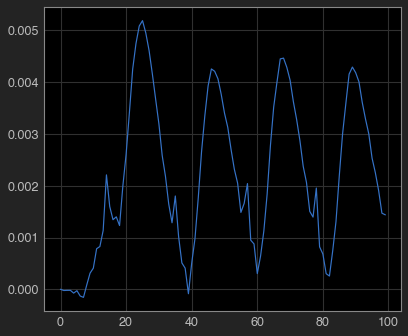

In [85]:
plt.plot((sol.y[0,:]**2 + sol.y[1,:]**2) - 1)

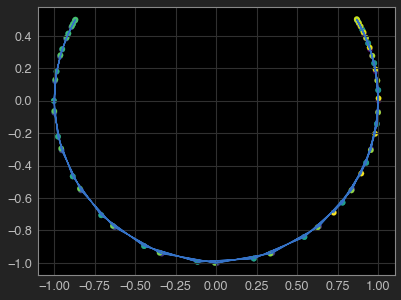

In [86]:
plt.plot(sol.y[0,:], sol.y[1,:])
plt.scatter(sol.y[0,:], sol.y[1,:], c=t_range)
plt.gca().set_aspect(1)

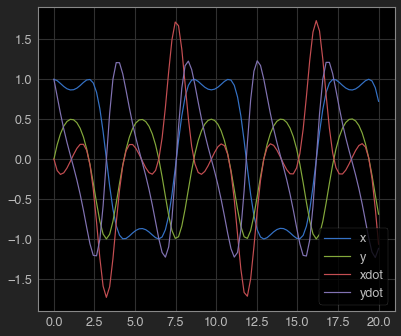

In [87]:
plt.plot(t_range, sol.y.T, label=['x','y','xdot','ydot'])
plt.legend()

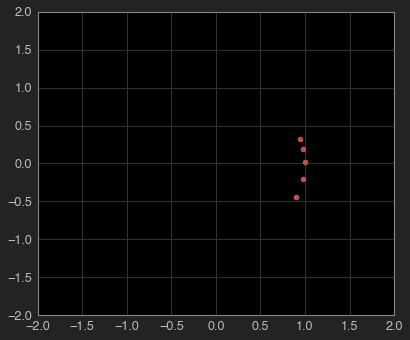

In [104]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro')
n_plot_points = 5

def init():
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    return ln,

def update(frame):
    imin = max(frame - n_plot_points, 0)
    ln.set_data(sol.y[0, imin:frame], sol.y[1, imin:frame])
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(sol.y.shape[1]),
                    init_func=init, blit=True)
HTML(ani.to_html5_video())

# general case

## definitions

In [3]:
from constraineddynamics.env import *

## solve ode

In [4]:
particle_system = ParticleSystem(dim=2, masses=ParticleVec(np.array([1.0, 1.0])))
constraints: List[Constraint] = [
    CircleConstraint(origin=np.array([0.0, 0.0]), radius=1, apply_to=0, ps=particle_system),
    CoupledCircleConstraint(radius=2, apply_to=[0, 1], ps=particle_system),
    PlanarConstraint(n=SpaceVec(np.array([0, 1.0])), p=SpaceVec(np.array([0.0, 0])), apply_to=1, ps=particle_system)
]
simulator = Simulator(particle_system, constraints)

q0 = particle_system.xs_to_q(SpaceVecs(np.array([
    [1.0, 0.0],
    [3.0, 0.0]
])))
qdot0 = particle_system.xs_to_q(SpaceVecs(np.array([
    [0, 2.0],
    [0.0, 0.0]
])))

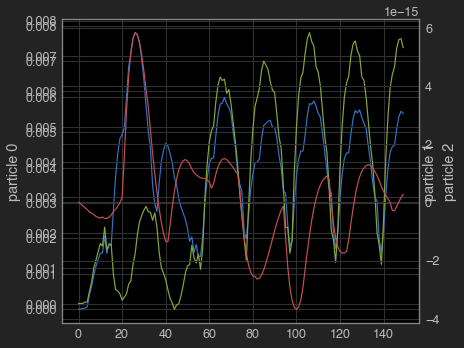

In [6]:
t_range = np.linspace(0, 30, 150)

sol = simulator.simulate(q0, qdot0, t_range)

#constraint_mapper.constraint(particle_system.y_to_q(y0))
constraint_values = np.array([simulator.constraint_mapper.constraint(particle_system.y_to_q(y)) for y in sol.y.T])

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, cv in enumerate(constraint_values.T):
    ax = plt.gca().twinx() if i > 0 else plt.gca()
    ax.plot(cv, c=colors[i])
    ax.set_ylabel(f'particle {i}')

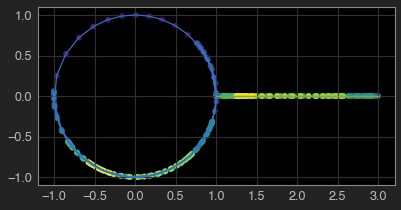

In [6]:
for x in np.array([
        particle_system.q_to_xs(particle_system.y_to_q(y)) for y in sol.y.T
]).transpose(1,0,2):
    plt.plot(x[:,0], x[:,1])
    plt.scatter(x[:,0], x[:,1], c=sol.t)
    plt.gca().set_aspect(1)

In [8]:
def energy(xs,xdots, ms):
    return sum(0.5 * m * np.dot(xdot, xdot) + m * x[1]  for x, xdot, m in zip(xs, xdots, ms))

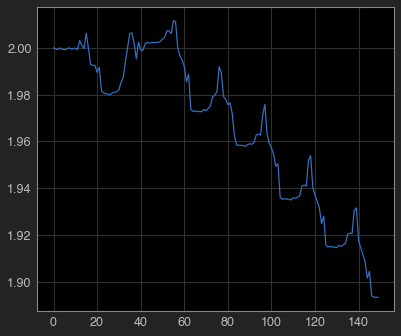

In [9]:
E_t = np.array([energy(*map(particle_system.q_to_xs,particle_system.y_to_qqdot(y)), particle_system.masses) for y in sol.y.T])
plt.plot(E_t)

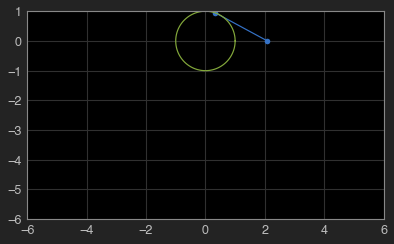

In [7]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
ax.set_aspect(1)
xdata, ydata = [], []
ln, = plt.plot([], [], marker='o')
(lambda x: plt.plot(1*np.cos(x),1*np.sin(x)))(np.linspace(0,np.pi*2,100))
n_plot_points = 5

def init():
    ax.set_xlim(-6,6)
    ax.set_ylim(-6,1)
    return ln,

def update(frame):
    imin = max(frame - n_plot_points, 0)
    ln.set_data(
        [sol.y[i*particle_system.dim, frame] for i in range(particle_system.n_particles)],
        [sol.y[i*particle_system.dim + 1, frame] for i in range(particle_system.n_particles)]
    )
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(sol.y.shape[1]),
                    init_func=init, blit=True, interval=33)
HTML(ani.to_html5_video())